<a href="https://colab.research.google.com/github/oriheldman/eurovision_social_analysis/blob/main/data_preprocessing_euroVotes_euroTour_euroTrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preprocecing - Eurovision Votes, Trade and Tourism

For each data type - eurovision votes, the trade and tourism between the countries, this notebook contains preprocecing of the data, preparation for graph representation and graph building.

Eurovision graph for each year - a directed graph, each node is a country participating, an edge from node i to node j exsists if country i gave points to country j. The weight of that edge is the normalized points country i gave to j.

Trade graph for each year - a directed graph, each node is a country, an edge from node i to node j exsists if country i exports to country j. The weight of that edge is the normalized export of all goods country i gave to j.

Tourism graph for each year - a directed graph, each node is a country, an edge from node i to node j exsists if country i reported tourism to country j. The weight of that edge is the oficial number reported by the county listed in the OECD database or the normalized reported number of all tourism.

###Imports and drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# drive.flush_and_unmount()

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
import re
import random
import json
import functools


#visualization libs
%matplotlib inline
#%config InlineBackend.figure_format ='retina'

import pylab as plt
import seaborn as sns
sns.set_style('whitegrid')
from ipywidgets.widgets import HTML
from tqdm import tqdm


#graph and network libs
import networkx as nx
import community as louvain


#machine learning libs
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn import decomposition, manifold

from gensim.models import Word2Vec

##Eurovision Graphs

### Eurovision dataset - load and clean 

In [5]:
eurovison_df = pd.read_csv('/content/drive/MyDrive/NLP-SD/Data/eurovision_votes_1975_2021.csv')
eurovison_df.columns = ['year','final','edition','votetype','countryfrom','countryto','points','duplicate']

In [8]:
# removing empty edges, duplicates and countries with few participations

def clean_data(eurovison_df, min_years = 5, last_participation=8):
    """
    eurovison_df: the original eurovision dataset
    min_year: minimum years of participations
    last_participation: has participated in the last x years
    """
    eurovison_df = eurovison_df.copy().query('points > 0')
    
    #Removing duplicates
    eurovison_df['duplicate'] = eurovison_df['duplicate'].apply(lambda x: True if x == 'x' or x==True else False)
    eurovison_df = eurovison_df.query('duplicate == False').drop(columns=['duplicate'])

    
    #Stantardazing countries names.
    def rename_country(x):
        renamings ={
            'North Macedonia':'Macedonia',
            'F.Y.R. Macedonia':'Macedonia',
            'The Netherands': 'Netherlands',
            'The Netherlands':'Netherlands',
            'Bosnia & Herzegovina':'Bosnia',
        }
        return renamings[x] if x in renamings else x

    eurovison_df['countryfrom'] = eurovison_df['countryfrom'].apply(rename_country)
    eurovison_df['countryto']   = eurovison_df['countryto'].apply(rename_country)

    #replicating  Yugoslavia's results to countries that part of it.
    division = {
        'Yugoslavia':['Macedonia','Serbia','Montenegro','Slovenia','Bosnia','Croatia'],
        'Serbia & Montenegro':['Serbia','Montenegro'],
    }
    
    eurovison_df['countryfrom'] = eurovison_df['countryfrom'].apply(lambda x:division[x] if x in division else x)
    eurovison_df['countryto']   = eurovison_df['countryto'].apply(lambda x:division[x] if x in division else x)
    eurovison_df = eurovison_df.explode('countryfrom').explode('countryto')
    

    # removing countries with less then x participations and not active in the last x years
    toKeep = eurovison_df.groupby('countryfrom').apply(
        lambda x:pd.Series({
            'years':x['year'].nunique(),
            'last_participation':eurovison_df['year'].max() - x['year'].max(),
            })).query(f'years >= {min_years} and last_participation <= {last_participation}').reset_index()['countryfrom'];
    
    display(HTML("<p>ignored countries: %s</p>" %', '.join(eurovison_df[eurovison_df['countryfrom'].isin(toKeep)==False]['countryfrom'].unique())))

    eurovison_df = eurovison_df[eurovison_df['countryfrom'].isin(toKeep)]
    eurovison_df = eurovison_df[eurovison_df['countryto'].isin(toKeep)]
    
    
    #keep only the points received at the highest stage (finals/semifinals)
    eurovison_df['finalcode']=eurovison_df.final.map({'f':1,'sf':2,'sf1':2,'sf2':2})
    temp1 = eurovison_df.groupby(['countryto','year']).agg({'finalcode':'min'});
    eurovison_df = pd.merge(eurovison_df,temp1, on=['countryto','year','finalcode'], how='inner')
    
    assert len(eurovison_df.groupby(['countryfrom','countryto','year']).agg({'final':'nunique'}).query('final >1')) == 0
    
    eurovison_df.drop(columns=['finalcode','edition'], inplace=True)
    
    return eurovison_df.reindex()

eurovison_df_c = clean_data(eurovison_df);
eurovison_df_c["normalized_points"] = eurovison_df_c['points'].apply(lambda point: point/57)
all_eurovision_countries = list(eurovison_df_c['countryfrom'].unique())


HTML(value='<p>ignored countries: Luxembourg, Monaco, Turkey, Morocco, Slovakia, Andorra</p>')

In [7]:
#use these function to filter out only the top N with most of point by countries
# or Top %percent of cumsum (useful for Pareto analysis).


def selectTopN(x,column, top=3):
    x = x.sort_values(column).tail(top)
    return x;

def selectTopPercent(x, column, percent=0.2, retrieve_first=True):
    x = x.sort_values(column, ascending=False)
    cut = x[column].cumsum() / x[column].sum();
    cut = cut <= percent;
    
    #return at least the first and avoid warnings
    if retrieve_first and cut.sum() ==0:
        return x.iloc[0];
    
    return x[cut==True];

def plot(g, title, ax=None):
  if ax == None:
      ax = plt.gca();
      
  ax.set_title(title);
  
  np.random.seed(12)
  pos=nx.kamada_kawai_layout(g,weight='weight');
  nx.draw(g,
      pos = pos,
      ax=ax,
      cmap=plt.cm.viridis_r,
      edge_color='#cccccc',
      node_color=list(nx.pagerank(g).values()),
      font_color='#000',
      with_labels=True,
  )

### Creating Eurovision Graphs

The following code will create a eurovision graph as discribed above for each year from 2015-2021 for countries in the final (2020 not included COVID-19 year). 

In [ ]:
def create_vote_graph():
  for year in range(2015, 2022):
    if year != 2020:
      for vote_type in ['T', 'J', 'J_T']:
        if year == 2015:
          eurovison_data = eurovison_df_c.query("year == {} and final == 'f' and votetype == 'J'".format(year))
        else:
          if vote_type == 'J_T':
            eurovison_data = eurovison_df_c.query("year == {} and final == 'f'".format(year))
            # sum both jury and televoters
            eurovison_data = eurovison_data.groupby(['countryfrom','countryto']).agg({'points':'sum'}).reset_index()
            eurovison_data["normalized_points"] = eurovison_data['points'].apply(lambda point: point/114)
          else:
            eurovison_data = eurovison_df_c.query("year == {} and final == 'f' and votetype == '{}'".format(year, vote_type))
        eurovison_data = eurovison_data.groupby(['countryfrom']).apply(selectTopN,'normalized_points',12).reset_index(drop=True)
        euro_vote_graph = nx.from_pandas_edgelist(eurovison_data,'countryfrom','countryto',['normalized_points'], create_using=nx.OrderedDiGraph)
        nx.write_gpickle(euro_vote_graph, "/content/drive/MyDrive/NLP-SD/Data/graphs/euro_votes_graph_{}_{}.gpickle".format(year, vote_type))

create_vote_graph()

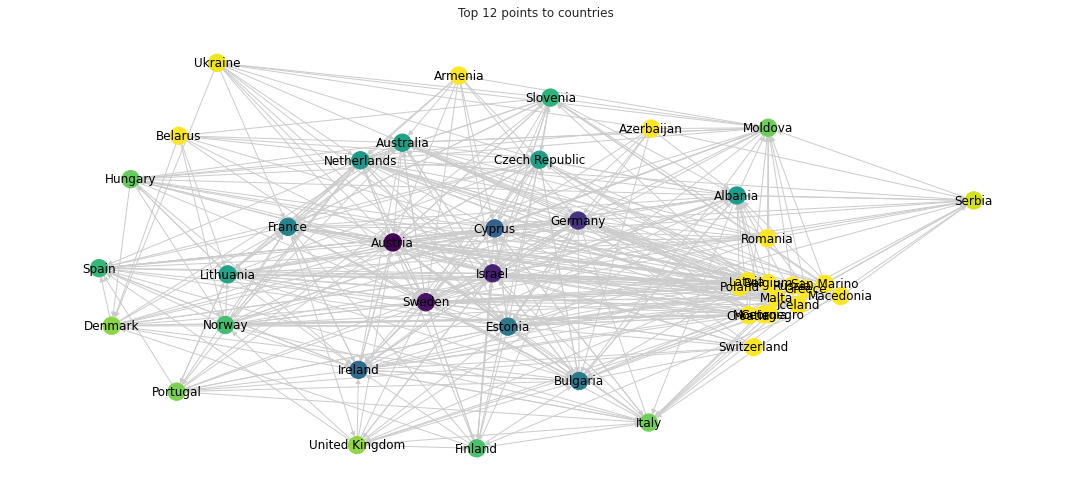

In [ ]:
#  Plotting exapmle of eurovision jury votes 2018 
plt.figure(figsize=(15,7));
plt.subplot(111);
G = nx.read_gpickle("/content/drive/MyDrive/NLP-SD/Data/graphs/euro_votes_graph_2018_J.gpickle")
plot(G,title='Top 12 points to countries',ax=plt.gca())
plt.tight_layout();

##Trade Graphs

### WITO export import data

An edge from A to B represents country A exporting goods to country B (or B importing from A). The weight of the this edge is proportinal to the magnitude of the trade both export and import. We compute the magnitude of trade w_edge = (0.5 * export) + (0.5 * import)

In [ ]:
# collecting trade data from WITS for all eurovision countries - helpfull lists:wits.get_products()wits.get_indicators()['definition']

# !pip install world_trade_data
import world_trade_data as wits
all_eurovision_countries = list(eurovison_df_c['countryfrom'].unique())

year_start = 2013

In [ ]:
def create_wito_data():
  wits_country_data = pd.read_csv('/content/drive/MyDrive/NLP-SD/Data/WITS_data/wits_country_data.csv')
  for country in all_eurovision_countries:
    year_end = 2020
    print(country)
    id_name = country
    if country == "Macedonia":
      country = "North Macedonia"
    elif country == "Serbia":
      country = "Serbia, FR(Serbia/Montenegro)"
    elif country == "Montenegro":
      year_end = 2019
    elif country =="Bosnia":
      country = "Bosnia and Herzegovina"
    elif country =="Russia":
      country = "Russian Federation"
    elif country == "Ukraine":
      year_end = 2019
    elif country == "San Marino":
      continue
    for year in range(year_start, year_end):
      country_code = wits_country_data.loc[wits_country_data['name'] == str(country), 'iso3Code'].iloc[0]
      exports = wits.get_indicator('XPRT-TRD-VL', reporter=country_code, partner="all",product="Total", year=str(year))
      exports.to_csv('/content/drive/MyDrive/NLP-SD/Data/WITS_data/{}_{}_exp.csv'.format(id_name, year))

create_wito_data()

In [ ]:
# creating a united dataset of trade - calculating precentage of trade
year_end = 2019
cols = ["Reporter", "Partner", "Year", "Value"]
all_trade_data = pd.DataFrame(columns=cols+["Share"])
for country in all_eurovision_countries:
  if country == "Montenegro":
    year_end = 2019
  elif country == "Ukraine":
    year_end = 2019
  elif country == "San Marino":
    continue
  for year in range(2013, year_end):
    trade_data = pd.read_csv('/content/drive/MyDrive/NLP-SD/Data/WITS_data/{}_{}_exp.csv'.format(country, year))[cols]
    world_val = trade_data.loc[trade_data['Partner'] == "World", 'Value'].iloc[0]
    trade_data["Share"] = trade_data["Value"].apply(lambda val: val/world_val)
    all_trade_data = all_trade_data.append(trade_data, ignore_index = True)

all_trade_data.loc[all_trade_data['Partner'] == "Macedonia, FYR", 'Partner'] = "Macedonia"
all_trade_data.loc[all_trade_data['Partner'] == "Serbia, FR(Serbia/Montenegro)", 'Partner'] = "Serbia"
all_trade_data.loc[all_trade_data['Partner'] == "Bosnia and Herzegovina", 'Partner'] = "Bosnia"
all_trade_data.loc[all_trade_data['Partner'] == "Russian Federation", 'Partner'] = "Russia"

all_trade_data.loc[all_trade_data['Reporter'] == "Macedonia, FYR", 'Reporter'] = "Macedonia"
all_trade_data.loc[all_trade_data['Reporter'] == "Serbia, FR(Serbia/Montenegro)", 'Reporter'] = "Serbia"
all_trade_data.loc[all_trade_data['Reporter'] == "Bosnia and Herzegovina", 'Reporter'] = "Bosnia"
all_trade_data.loc[all_trade_data['Reporter'] == "Russian Federation", 'Reporter'] = "Russia"


# remove all World partners
all_trade_data = all_trade_data[all_trade_data["Partner"] != "World"]
all_trade_data.to_csv('/content/drive/MyDrive/NLP-SD/Data/eurvis_countries_trade_data.csv')


In [ ]:
all_eurovision_countries = list(eurovison_df_c['countryfrom'].unique())

def create_trade_graph():
  for year in range(year_start, 2019):
    trade_data = all_trade_data.query('Partner in @all_eurovision_countries and Year == {}'.format(year))
    # trade_data = trade_data.groupby(['Reporter']).apply(selectTopN,'Share',12).reset_index(drop=True)
    euro_trade_graph = nx.from_pandas_edgelist(trade_data,'Reporter','Partner',['Share'], create_using=nx.OrderedDiGraph)
    nx.write_gpickle(euro_trade_graph, "/content/drive/MyDrive/NLP-SD/Data/graphs/euro_trade_graph_all{}.gpickle".format(year))


def create_trade_graph_final():
  for year in range(year_start, 2019):
    final_c = list(eurovison_df.query('final == "f" and year == {}'.format(year))['countryto'].unique())
    trade_data = all_trade_data.query('Partner in @final_c and Year == {}'.format(year))
    # trade_data = trade_data.groupby(['Reporter']).apply(selectTopN,'Share',12).reset_index(drop=True)
    euro_trade_graph = nx.from_pandas_edgelist(trade_data,'Reporter','Partner',['Share'], create_using=nx.OrderedDiGraph)
    nx.write_gpickle(euro_trade_graph, "/content/drive/MyDrive/NLP-SD/Data/graphs/euro_trade_graph_final_{}.gpickle".format(year))


create_trade_graph()
create_trade_graph_final()

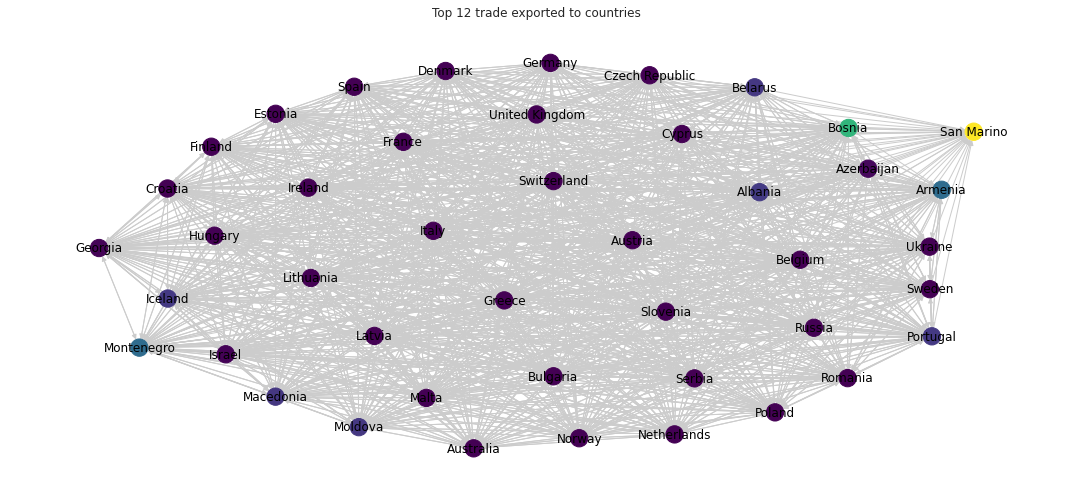

In [25]:
#  Plotting exapmle of euro trade 2018 
plt.figure(figsize=(15,7));
plt.subplot(111);
G_all = nx.read_gpickle("/content/drive/MyDrive/NLP-SD/Data/graphs/euro_trade_graph_all2018.gpickle")
plot(G_all,title='Top 12 trade exported to countries',ax=plt.gca())
plt.tight_layout();

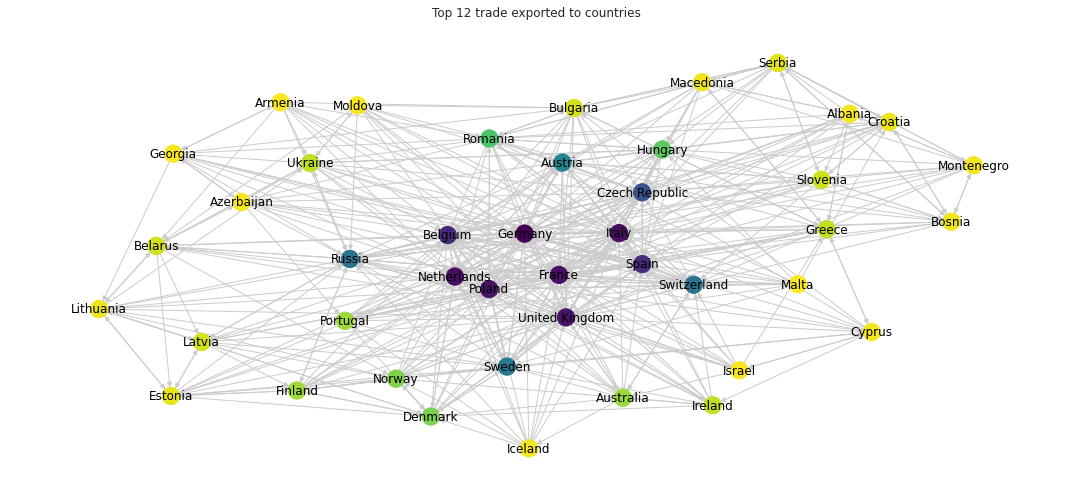

In [23]:
#  Plotting exapmle of euro trade 2018 
plt.figure(figsize=(15,7));
plt.subplot(111);
G = nx.read_gpickle("/content/drive/MyDrive/NLP-SD/Data/graphs/euro_trade_graph_2018.gpickle")
plot(G,title='Top 12 trade exported to countries',ax=plt.gca())
plt.tight_layout();

#Tourisem Data

##Clean and Preprocess data

In [3]:
tour_country_data = pd.read_excel('/content/drive/MyDrive/NLP-SD/Data/TOUR_EU_2013_2019.xlsx', header=[0,1], index_col=[0] ).dropna(axis=1, how='all').replace(":", 0)

In [ ]:
# tour_country_data['2013'][all_eurovision_countries]
# len([c for c in all_eurovision_countries if c in tour_country_data['2013'].columns])

def create_tour_dataset_for_graph_normed(tour_df, years_list, all_eurovision_countries):
  """
  years_list - list of years as strings 
  """
  for year in years_list:
    f = [c for c in all_eurovision_countries if c in tour_df[year].columns]
    curr = tour_df[year][f + ["sum"]]
    curr = curr.div(curr["sum"], axis = 0).fillna(0).reset_index()
    curr = pd.melt(curr, id_vars=['index'], value_vars=f)
    curr = curr[curr['index'] != curr['PARTNER (Labels)']]
    curr.columns = ["reporter", "partner", "weight"]
    curr = curr.reset_index(drop = True)
    curr.to_csv("/content/drive/MyDrive/NLP-SD/Data/tour_data/tour_{}".format(year))


def create_tour_dataset_for_graph(tour_df, years_list, all_eurovision_countries):
  """
  years_list - list of years as strings 
  """
  for year in years_list:
    f = [c for c in all_eurovision_countries if c in tour_df[year].columns]
    curr = tour_df[year][f].reset_index()
    curr = pd.melt(curr, id_vars=['index'], value_vars=f)
    curr = curr[curr['index'] != curr['PARTNER (Labels)']]
    curr.columns = ["reporter", "partner", "weight"]
    curr = curr.reset_index(drop = True)
    curr.to_csv("/content/drive/MyDrive/NLP-SD/Data/tour_data/tour_no_norm_{}".format(year))

years_list = [str(a) for a in range(2013,2020)]
create_tour_dataset_for_graph(tour_country_data, years_list, all_eurovision_countries)


## Create Tourist Graph

In [ ]:
tour_data = pd.read_csv("/content/drive/MyDrive/NLP-SD/Data/tour_data/tour_{}".format(2014))
tour_data.groupby(['reporter']).apply(selectTopN,'weight',12)

In [22]:
def create_tour_graph(years_list):
  for year in years_list:
    tour_data = pd.read_csv("/content/drive/MyDrive/NLP-SD/Data/tour_data/tour_no_norm_{}".format(year))
    # tour_data = tour_data.groupby(['reporter']).apply(selectTopN,'weight',12).reset_index(drop=True)
    tour_graph = nx.from_pandas_edgelist(tour_data,'reporter','partner',['weight'], create_using=nx.OrderedDiGraph)
    nx.write_gpickle(tour_graph, "/content/drive/MyDrive/NLP-SD/Data/graphs/tour_graph_no_norm_{}.gpickle".format(year))

create_tour_graph(years_list)

/usr/local/lib/python3.7/dist-packages/networkx/drawing/layout.py:739: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


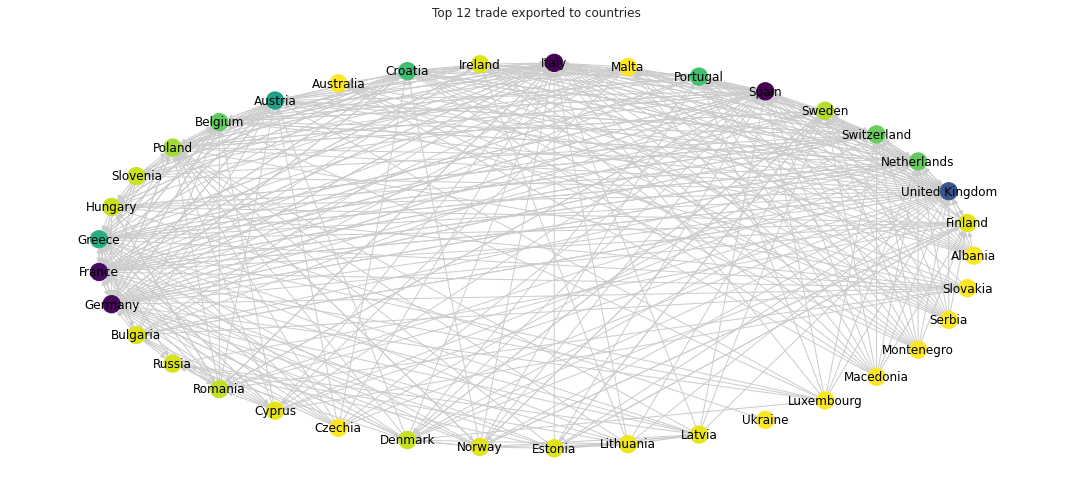

In [ ]:
#  Plotting exapmle of euro trade 2018 
plt.figure(figsize=(15,7));
plt.subplot(111);
G = nx.read_gpickle("/content/drive/MyDrive/NLP-SD/Data/graphs/tour_graph_2014.gpickle")
plot(G,title='Top 12 trade exported to countries',ax=plt.gca())
plt.tight_layout();